# Análisis Exploratorio Navent

In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import os
path_working_directory = os.getcwd()

educacion = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_1_postulantes_educacion.csv"), low_memory=False)
genero_edad = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_2_postulantes_genero_y_edad.csv"), low_memory=False)
visitas = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_3_vistas.csv"), low_memory=False)
postulaciones = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_4_postulaciones.csv"), low_memory=False)
avisos_online = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_5_avisos_online.csv"), low_memory=False)
avisos_detalles = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_6_avisos_detalle.csv"), low_memory=False)

Primero veremos algunas filas de cada uno de los dataframes levantados

In [3]:
educacion.head(5)

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


In [4]:
genero_edad.head(5)

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,5awk,1962-12-04,FEM
2,ZaO5,1978-08-10,FEM
3,NdJl,1969-05-09,MASC
4,eo2p,1981-02-16,MASC


In [5]:
visitas.head(5)

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [6]:
postulaciones.head(5)

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [7]:
avisos_online.head(5)

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [8]:
avisos_detalles.head(5)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,1,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,1,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


## Limpieza de los sets de datos

### Set de género y fechas de nacimiento

In [9]:
print "Cantidad de usuarios:", len(genero_edad), '\n'
print "Los usuarios son únicos:", len(genero_edad) == len(genero_edad.groupby('idpostulante')), '\n'
print genero_edad.isnull().any(), '\n'
print genero_edad.isnull().sum(), '\n'
print genero_edad.dtypes, '\n'

Cantidad de usuarios: 200888 

Los usuarios son únicos: True 

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool 

idpostulante          0
fechanacimiento    4750
sexo                  0
dtype: int64 

idpostulante       object
fechanacimiento    object
sexo               object
dtype: object 



Como se puede observar, existen 4750 usuarios de 200888 que no declaran su fecha de nacimiento (es decir, aproximadamente un 2,36%). Para que el set de datos esté completo se podría rellenar los datos faltantes realizando una regresión o sacando un promedio siguiendo algún tipo de criterio. Sin embargo, como la cantidad de usuarios en cuestión es baja, se los puede eliminar del set de datos. Antes de realizar esto se analizará cuántas postulaciones y visitas corresponden a usuarios sin fecha de nacimiento, para ver si eliminar dichos usuarios implica quitar muchas postulaciones y visitas a avisos de los demas sets de datos.

In [10]:
no_declaran_edad = genero_edad[genero_edad.fechanacimiento.isnull()]
print len(no_declaran_edad), "postulantes no declaran edad", '\n'
declaran_edad = genero_edad[genero_edad.fechanacimiento.notnull()]
print len(declaran_edad), "postulantes declaran edad", '\n'
postulaciones_sin_fecha_nacimiento = pd.merge(no_declaran_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_sin_fecha_nacimiento), "postulaciones de usuarios sin fecha de nacimiento de", len(postulaciones), '\n'
visitas_sin_fecha_nacimiento = pd.merge(no_declaran_edad, visitas, how='inner', on='idpostulante')
print len(visitas_sin_fecha_nacimiento), "visitas de usuarios sin fecha de nacimiento de", len(visitas)

4750 postulantes no declaran edad 

196138 postulantes declaran edad 

44464 postulaciones de usuarios sin fecha de nacimiento de 3401623 

22767 visitas de usuarios sin fecha de nacimiento de 961897


Aproximadamente un 1,31% de las postulaciones corresponden a usuarios sin fecha de nacimiento mientras que en el caso de las visitas es de un 2,37%. Teniendo en cuenta que estos valores son pequeños, podemos optar por eliminar los usuarios sin fecha de nacimiento (y hacer lo propio con sus postulaciones y visitas a avisos).

In [11]:
genero_edad_filtrado = genero_edad[genero_edad.fechanacimiento.notnull()]

In [12]:
len(genero_edad_filtrado)

196138

### Set de estudios

In [13]:
print educacion.isnull().any(), '\n'
print educacion.describe(include='all'), '\n'
print educacion.dtypes, '\n'
print educacion.nombre.value_counts(), '\n'
print educacion.estado.value_counts(), '\n'

idpostulante    False
nombre          False
estado          False
dtype: bool 

       idpostulante      nombre    estado
count        298231      298231    298231
unique       188752           7         3
top          YlMLGD  Secundario  Graduado
freq              9      110256    194474 

idpostulante    object
nombre          object
estado          object
dtype: object 

Secundario           110256
Universitario        104295
Terciario/Técnico     47733
Otro                  24748
Posgrado               7387
Master                 3598
Doctorado               214
Name: nombre, dtype: int64 

Graduado      194474
En Curso       78531
Abandonado     25226
Name: estado, dtype: int64 



Se puede observar que en algunos casos existen múltiples entradas de estudio por usuario. A continuación se analizará el caso del usuario que tiene más entradas, cuyo id es YlMLGD:

In [14]:
educacion[educacion['idpostulante'] == 'YlMLGD']

,idpostulante,nombre,estado
373,YlMLGD,Terciario/Técnico,En Curso
374,YlMLGD,Otro,En Curso
375,YlMLGD,Universitario,En Curso
2206,YlMLGD,Terciario/Técnico,Graduado
2207,YlMLGD,Universitario,Graduado
2208,YlMLGD,Otro,Graduado
2209,YlMLGD,Posgrado,Graduado
3659,YlMLGD,Universitario,Abandonado
3660,YlMLGD,Terciario/Técnico,Abandonado


Podemos ver que este usuario presenta múltiples entradas con estudios con estado En Curso, Graduado y Abandonado. A su vez, aparencen múltiples entradas para un mismo tipo de estudio, como es el caso de Universitario.
Para poder analizar mejor los datos de educación, se optó por generar un dataframe que tenga una fila por cada usuario donde sus columnas sean el id del usuario (idpostulante), el mayor nivel de estudio en el que se graduó (estudio_graduado) y el mayor nivel de estudio que tiene en curso (estudio_en_curso), que a su vez debe ser mayor al nivel que tiene en la columna estudio_graduado.
Se definió que el nivel de estudio, de menor a mayor, sea el siguiente: 
Otro, Secundario, Terciario/Técnico, Universitario, Master, Posgrado y Doctorado.

In [15]:
tipos_de_estudio = ['', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
def get_dict_tipos_de_estudio():
    dict = {}
    for x in range(len(tipos_de_estudio)):
        dict[tipos_de_estudio[x]] = x
    return dict

dict_tipos_de_estudio = get_dict_tipos_de_estudio()

def mejor_estudio(estudio1, estudio2):
    return tipos_de_estudio[max(tipos_de_estudio.index(estudio1), tipos_de_estudio.index(estudio2))]

en_curso = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'En Curso' else 0, axis=1)
graduado = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'Graduado' else 0, axis=1)
educacion2 = educacion.assign(estudio_en_curso=en_curso)
educacion2 = educacion2.assign(estudio_graduado=graduado)

In [16]:
educacion_grupos = educacion2.groupby('idpostulante')
educacion_nueva = pd.DataFrame({
    'estudio_en_curso': educacion_grupos['estudio_en_curso'].max(),
    'estudio_graduado': educacion_grupos['estudio_graduado'].max()
}).reset_index()
educacion_nueva['estudio_en_curso'] = educacion_nueva.apply(lambda x: tipos_de_estudio[x['estudio_en_curso']] if x['estudio_en_curso'] > x['estudio_graduado'] else '', axis=1)
educacion_nueva['estudio_graduado'] = educacion_nueva['estudio_graduado'].apply(lambda x: tipos_de_estudio[x])
print len(educacion_nueva)
educacion_nueva[educacion_nueva['idpostulante'] == 'YlMLGD']

188752


,idpostulante,estudio_en_curso,estudio_graduado
117605,YlMLGD,,Posgrado


El usuario YlMLGD no tiene una entrada en la columna de estudio en curso dado que esta graduado en un Posgrado (y su mayor estudio en curso es Universitario, que tiene un menor nivel). 
De esta manera, se tiene una única entrada por cada usuario y la cantidad de entradas se corresponde con la cantidad de valores únicos en el dataframe original.

Solamente queremos mantener usuarios que tengan informacion sobre su educacion:

In [17]:
usuarios_educacion_edad = pd.merge(genero_edad_filtrado, educacion_nueva, on='idpostulante', how='inner')
len(usuarios_educacion_edad)

185878

Dentro de los usuarios con entradas de educación, la cantidad de usuarios sin fecha de nacimiento no es alta (2874 de 188752, que es un 1,52%) y dado que se quería realizar un análisis teniendo en cuenta esta información, se optó por borrarlos.

In [18]:
postulaciones_total = len(postulaciones)
postulaciones_filtrado = pd.merge(usuarios_educacion_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_filtrado), "postulaciones de usuarios con fecha de nacimiento y educacion de", postulaciones_total, '\n'
visitas_total = len(visitas)
visitas_filtrado = pd.merge(usuarios_educacion_edad, visitas, how='inner', on='idpostulante')
print len(visitas_filtrado), "visitas de usuarios con fecha de nacimiento y educacion de", visitas_total

3268054 postulaciones de usuarios con fecha de nacimiento y educacion de 3401623 

895478 visitas de usuarios con fecha de nacimiento y educacion de 961897


Esto implica que eliminamos el 3,92% de las postulaciones, el 6,91% de las visitas y 7,47% de los usuarios (teniendo en cuenta como total el número de entradas del csv de género y edad). Esto se realizó con el fin de tener dataframes de usuarios con su información completa (fecha de nacimiento y su educación)

In [19]:
visitas_filtrado.rename(index=str, columns={'idAviso': 'idaviso'}, inplace=True)
visitas_filtrado.head(1)

,idpostulante,fechanacimiento,sexo,estudio_en_curso,estudio_graduado,idaviso,timestamp
0,5awk,1962-12-04,FEM,,Universitario,1112315188,2018-02-28T15:53:48.610-0500


### Set de datos con detalles de avisos

In [20]:
print "Los avisos son únicos:", len(avisos_detalles) == len(avisos_detalles.groupby('idaviso')), '\n'
print 'Columnas con valores nulos:'
print avisos_detalles.isnull().any(), '\n'
print 'Cantidad de valores nulos por columna'
print avisos_detalles.isnull().sum(), '\n'
print avisos_detalles.dtypes, '\n'
print 'Cantidad de avisos:', len(avisos_detalles), '\n'

Los avisos son únicos: True 

Columnas con valores nulos:
idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool 

Cantidad de valores nulos por columna
idaviso                     0
idpais                      0
titulo                      0
descripcion                 0
nombre_zona                 0
ciudad                  13487
mapacalle               12662
tipo_de_trabajo             0
nivel_laboral               0
nombre_area                 0
denominacion_empresa        5
dtype: int64 

idaviso                  int64
idpais                   int64
titulo                  object
descripcion             object
nombre_zona             object
ciudad                  object
mapacalle               objec

Se puede observar que la gran mayoría de las filas no poseen datos en las columnas ciudad y mapacalle, por lo que optamos por sacarlas del dataframe.

In [21]:
avisos_detalles.drop('ciudad', axis=1, inplace=True)
avisos_detalles.drop('mapacalle', axis=1, inplace=True)

In [22]:
avisos_detalles.head(1)

,idaviso,idpais,titulo,descripcion,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,VENTOR


Otro cuestión observada es que salvo 5 avisos, todos los demas tienen el nombre de la empresa. Analizaremos si eliminar esos 5 avisos del set de datos produce una pérdida importante de postulaciones y visitas

In [23]:
avisos_sin_empresa = avisos_detalles[avisos_detalles.denominacion_empresa.isnull()]
postulaciones_avisos_sin_empresa = pd.merge(postulaciones_filtrado, avisos_sin_empresa, on='idaviso', how='inner')
visitas_avisos_sin_empresa = pd.merge(visitas_filtrado, avisos_sin_empresa, on='idaviso', how='inner')
print 'Postulaciones correspondientes a avisos sin empresas:', len(postulaciones_avisos_sin_empresa), "de", len(postulaciones_filtrado), '\n'
print 'Visitas correspondientes a avisos sin empresas:', len(visitas_avisos_sin_empresa), "de", len(visitas_filtrado), '\n'

# postulaciones_avisos_sin_empresa_iniciales = pd.merge(postulaciones, avisos_sin_empresa, on='idaviso', how='inner')
# visitas.rename(index=str, columns={'idAviso': 'idaviso'}, inplace=True)
# visitas_avisos_sin_empresa_sin_filtro_iniciales = pd.merge(visitas, avisos_sin_empresa, on='idaviso', how='inner')
# print 'Postulaciones correspondientes a avisos sin empresas en dataframe original:', len(postulaciones_avisos_sin_empresa_iniciales), '\n'
# print 'Visitas correspondientes a avisos sin empresas en dataframe original:', len(visitas_avisos_sin_empresa_sin_filtro_iniciales), '\n'

Postulaciones correspondientes a avisos sin empresas: 236 de 3268054 

Visitas correspondientes a avisos sin empresas: 1 de 895478 



La cantidad de postulaciones y visitas que pertenecen a estos avisos es ínfima, por lo que se los sacará del dataframe.

In [24]:
avisos_detalles_filtrado = avisos_detalles[avisos_detalles.denominacion_empresa.notnull()]
postulaciones_filtrado = postulaciones_filtrado[~postulaciones_filtrado.idaviso.isin(avisos_sin_empresa.idaviso)]
visitas_filtrado = visitas_filtrado[~visitas_filtrado.idaviso.isin(avisos_sin_empresa.idaviso)]
print len(avisos_online)
avisos_online = avisos_online[~avisos_online.idaviso.isin(avisos_sin_empresa.idaviso)]
print len(avisos_online)

5028
5028


### Análisis

In [25]:
postulaciones_por_usuario_filtrado = pd.DataFrame({
    'postulaciones_totales': postulaciones_filtrado.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
print postulaciones_por_usuario_filtrado.postulaciones_totales.head(5), '\n'
print postulaciones_por_usuario_filtrado.postulaciones_totales.tail(5), '\n'
print postulaciones_por_usuario_filtrado.describe(include='all'), '\n'

0    34
1     3
2    17
3     1
4     1
Name: postulaciones_totales, dtype: int64 

185873     3
185874     5
185875    10
185876    11
185877    28
Name: postulaciones_totales, dtype: int64 

       idpostulante  postulaciones_totales
count        185878          185878.000000
unique       185878                    NaN
top         Rz6VOrE                    NaN
freq              1                    NaN
mean            NaN              17.580445
std             NaN              32.148423
min             NaN               1.000000
25%             NaN               4.000000
50%             NaN               9.000000
75%             NaN              19.000000
max             NaN            3166.000000 



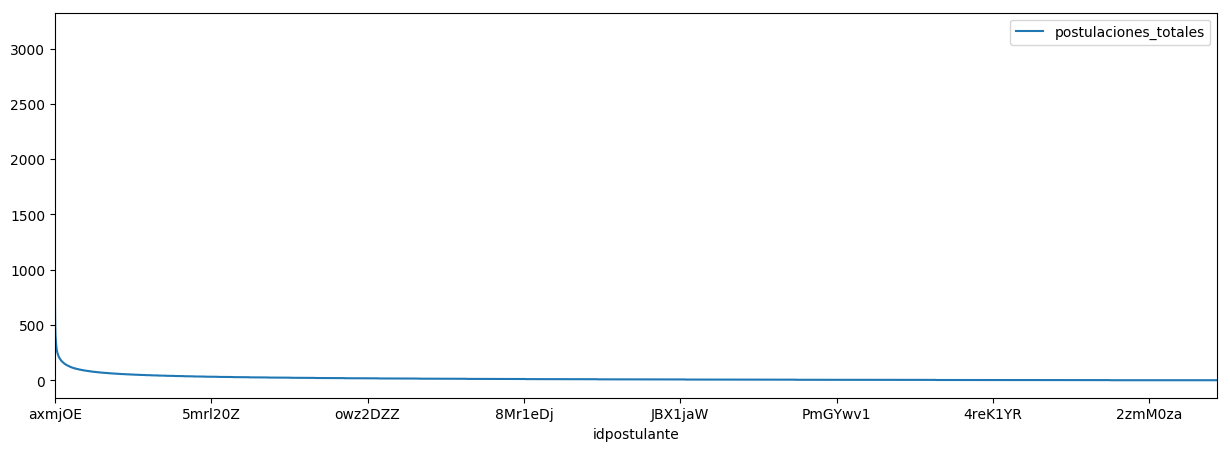

In [26]:
postulaciones_por_usuario_filtrado = postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales', ascending=False)
postulaciones_por_usuario_filtrado.plot(x='idpostulante', y='postulaciones_totales', kind='line')

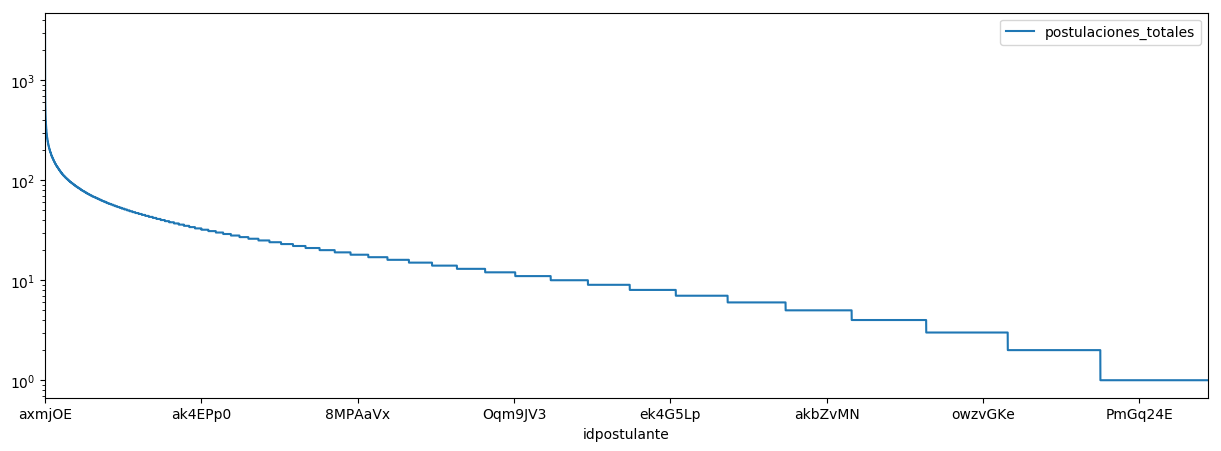

In [27]:
# Grafico en de postulaciones por usuario en escala logaritmica
postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales', ascending=False).plot(x='idpostulante', y='postulaciones_totales', kind='line', logy=True)

A partir de estos gráficos podemos ver que la distribución de las postulaciones por usuario es similar a una distribución de Pareto. Sin embargo, analizando los datos ...... (analizar si hay outliers, ver rango de fechas entre las postulaciones)

In [ ]:
# Como hacer un concat de series y eliminar duplicados
# idaviso_post_sin_fecha_nacimiento = postulaciones_sin_fecha_nacimiento.idaviso
# idaviso_visitas_sin_fecha_nacimiento = visitas_sin_fecha_nacimiento.idAviso
# len(idaviso_post_sin_fecha_nacimiento)
# len(idaviso_visitas_sin_fecha_nacimiento)
# avisos_de_postulantes_sin_fecha_nacimiento = pd.concat([idaviso_post_sin_fecha_nacimiento, idaviso_visitas_sin_fecha_nacimiento], ignore_index=True)
# avisos_de_postulantes_sin_fecha_nacimiento = avisos_de_postulantes_sin_fecha_nacimiento.drop_duplicates()